In [1]:
import os
import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt
import timeit
from time import sleep
import cv2.aruco as aruco
import math
from IPython.display import display, clear_output

import math, sys, os
sys.path.insert(0, os.path.join(os.getcwd(), 'src'))

from plotter import *
from kalman import *
from motion import *
from timer import *
# from global_utils import convert_to_np,sort_coords,vis_graph,heuristic,a_star,plot_map,swap_xy
from global_utils_new import *
from vision_utils import *

In [2]:
import tdmclient.notebook
await tdmclient.notebook.start()

In [3]:
%%run_python

state = 1

@onevent
def move(speed_left, speed_right):
    global motor_left_target, motor_right_target, state
    if state == 1 :
        motor_left_target = speed_left
        motor_right_target = speed_right
    
@onevent 
def button_center():
    global state, motor_left_target, motor_right_target
    state = 0
    motor_left_target = 0
    motor_right_target = 0

In [4]:
def send_command():
    if command[step][0] == command[step][1] and command[step][0] != 0:
        send_event("move", command[step][0] + 2, command[step][1] - 2)
    else :
        send_event("move", command[step][0], command[step][1])
        
@tdmclient.notebook.sync_var
def get_speed():
    return motor_left_speed, motor_right_speed
        
@tdmclient.notebook.sync_var
def prox_list():
    return list(prox_horizontal)

In [5]:
@tdmclient.notebook.sync_var
def get_speed():
    return motor_left_speed, motor_right_speed

def kalman_call():
    global step, x_est, P_est, rt, camera_pos, cam_OK, local_mode, local_mode_exit, command
    
    if step < len(command) :
        #retrieves the command that was applied Ts seconds ago
        speed_left = command[step][0]
        speed_right = command[step][1]
        
        #gets the right matrix corresponding to the command :
        #Thymio goes forward
        if speed_left == speed_right :
            A = A_F

        #Thymio is rotating
        else :
            A = A_R
            
        #measures the speed of the robot
        meas_speed_left,  meas_speed_right = get_speed()
        
        #get the last measured position
        meas_pos = camera_pos
            

        #computes the estimated states
        new_x_est, new_P_est = kalman_filter(meas_pos, meas_speed_left, meas_speed_right, x_est, P_est, A, cam_OK)

        x_est = new_x_est
        P_est = new_P_est
        
        step += 1
        
        if step < len(command) :
            send_command()
    else :
        if local_mode :
            local_mode = False
            local_mode_exit = True
        command = []
        step = 0

In [6]:
@tdmclient.notebook.sync_var
def mode_control():
    global local_mode_exit,local_mode,prox_horizontal,x_est,correction_mode,optimal_path,command,step,correction_mode
    prox_list = prox_horizontal[:5]
#     line_angle, distance = correct_path((x_est[0][0], x_est[1][0]), nodes_of_command[step][0] , nodes_of_command[step][1])
    
    print(max(prox_list))
    print(local_mode)
    if max(prox_list) > 3000 and not local_mode:      #enters local avoidance mode\
        print('Entering Local Avoidnace Mode')
        local_mode_exit = False
        local_mode = True
#         local_avoidance(prox_list.index(max(prox_list)))
        local_avoidance(prox_horizontal[:5].index(max(prox_horizontal[:5])))
    
    elif local_mode_exit :              #recomputes optimal path at exit of local avoidance 
        local_mode_exit = False
    
    elif not correction_mode:
        correction_mode = True
        if (np.linalg.norm(optimal_path[1][1]-np.squeeze(x_est[:2].transpose())) < 30):
            optimal_path = optimal_path[1:]
            
        angle, distance = calibrate_path(np.squeeze(x_est[:3].transpose()),optimal_path[1][1])
        
        if step >= len(command):
            last_command = [0, 0]
        
        else :
            last_command = command[step]
        command = [last_command]

        step = 0
        
        if angle > 0:
            command += turn_left(angle)
        else :
            command += turn_right(angle)
        
        command += move_forward(distance) + [[0, 0]]
        
    elif correction_mode and step >= 10 :
        correction_mode = False
            
        
        
#     elif ((abs(line_angle - x_est[2][0]) > np.deg2rad(5)) or (distance > 30) and not correction_mode and not local_mode):
        
#         print('Entering Correction Mode')
        
#     elif corre_mode_exit :              #recomputes optimal path at exit of local avoidance 
#         local_mode_exit = False

In [7]:
def local_avoidance(index):
    global command, step
    
    if step >= len(command):
        last_command = [0, 0]
        
    else :
        last_command = command[step]
        
    step = 0
    if index == 0 :     #left most sensor
        command = [last_command] + turn_right(np.deg2rad(20)) + move_forward(50) + [[0, 0]]
    elif index == 1 :
        command = [last_command] + turn_right(np.deg2rad(35)) + move_forward(50) + [[0, 0]]
    elif index == 2 :
        command = [last_command] + turn_right(np.deg2rad(50)) + move_forward(50) + [[0, 0]]
    elif index == 3 :
        command = [last_command] + turn_left(np.deg2rad(35)) + move_forward(50) + [[0, 0]]
    elif index == 4 :
        command = [last_command] + turn_left(np.deg2rad(20)) + move_forward(50) + [[0, 0]]

In [8]:
# def local_avoidance():
#     global command, step
    
#     if step >= len(command):
#         last_command = [0, 0]
        
#     else :
#         last_command = command[step]
        
#     step = 0
#     command = [last_command] + [[0, 0]]

## Dynamic plotting in main loop

In [9]:
thymio_icon = cv2.imread('Thymio.jpg')
thymio_icon = cv2.cvtColor(thymio_icon, cv2.COLOR_RGB2BGR)
def vision_update(): #40ms cycle
    global cap, frame, cam_OK, img_out, camera_pos,x_est,\
           Thymio_center, Thymio_dir, Thymio_target,\
           warpedimg_clean_annotated, warpedimg_annotated
    thymio_filtered = x_est
    ret, frame_tmp = cap.read()
    if ret:
        frame = cv2.cvtColor(frame_tmp, cv2.COLOR_BGR2RGB)
#     frame = cv2.cvtColor(frame_tmp, cv2.COLOR_BGR2RGB)
#     warpedimg = frame
#     warpedimg_clean = frame
#     frame = cv2.cvtColor(frame_tmp, cv2.COLOR_BGR2RGB)
    cam_OK, Thymio_center_tmp, Thymio_dir_tmp, warpedimg_tmp = localisation_cam(frame)
    thymio_filtered = x_est
    if cam_OK:
        Thymio_center, Thymio_dir, warpedimg = Thymio_center_tmp, Thymio_dir_tmp, warpedimg_tmp
        warpedimg_annotated = overlay_vis_graph([int(Thymio_start[0]),int(Thymio_start[1])],[int(thymio_filtered[0][0]),int(thymio_filtered[1][0])], [int(Thymio_target[0]),int(Thymio_target[1])], obs_corners, optimal_path, warpedimg)
        camera_pos = np.array(Thymio_center + [np.deg2rad(Thymio_dir)]).reshape(3,1)
    warpedimg_clean = merge_img(img_out, rotate_image(thymio_icon,np.rad2deg(thymio_filtered[2][0])), int(thymio_filtered[0][0])-120, int(thymio_filtered[0][0])+120, int(thymio_filtered[1][0])-120, int(thymio_filtered[1][0])+120)[:,:,0:3]
    warpedimg_clean_annotated = overlay_vis_graph([int(Thymio_start[0]),int(Thymio_start[1])],[int(thymio_filtered[0][0]),int(thymio_filtered[1][0])], [int(Thymio_target[0]),int(Thymio_target[1])], obs_corners, optimal_path, warpedimg_clean)

Unchecked ExtSlice(dims=[Slice(lower=None, upper=None, step=None), Slice(lower=None, upper=None, step=None), Slice(lower=Constant(value=0, kind=None), upper=Constant(value=3, kind=None), step=None)])


In [10]:
#setup camera
cap = cv2.VideoCapture(0,cv2.CAP_DSHOW)
cap.set(cv2.CAP_PROP_FRAME_WIDTH, 1280)
cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 720)
cap.set(cv2.CAP_PROP_EXPOSURE, -4)  #adjust this to avoid reflection from A4 paper

True

In [13]:
ret, frame = cap.read()
sleep(1)
ret, frame = cap.read()
frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

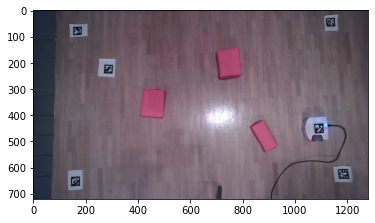

In [14]:
plt.imshow(frame)

In [15]:
cam_OK, Thymio_start, Thymio_dir, Thymio_target, obs_corners, obstacles_mask, img_out = localisation_cam_all(frame)

In [16]:
cam_OK

True

In [17]:
#camera warmup run at start up to get stable frames
leds_bottom_left = [0, 0, 0]
leds_bottom_right = [0, 0, 0]
ret, frame = cap.read()
while(not ret):
    cap = cv2.VideoCapture(0,cv2.CAP_DSHOW)
frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
sleep(1)
ret, frame = cap.read()
while(not ret):
    cap = cv2.VideoCapture(0,cv2.CAP_DSHOW)
frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    
#run one time or when replanning
cam_OK, Thymio_start, Thymio_dir, Thymio_target, obs_corners, obstacles_mask, img_out = localisation_cam_all(frame)

discretized_path, optimal_path = do_global_navigation(obs_corners, Thymio_start+[np.deg2rad(Thymio_dir)], Thymio_target+[0.0])
global_command = calc_commands(discretized_path)
nodes_of_command = get_nodes_of_commands(discretized_path, global_command)


# first plot
Thymio_center = Thymio_start
cam_OK, Thymio_center_tmp, Thymio_dir_tmp, warpedimg_tmp = localisation_cam(frame)
Thymio_center, Thymio_dir, warpedimg = Thymio_center_tmp, Thymio_dir_tmp, warpedimg_tmp
warpedimg_clean = merge_img(img_out, rotate_image(thymio_icon,Thymio_dir), int(Thymio_center[0])-120, int(Thymio_center[0])+120, int(Thymio_center[1])-120, int(Thymio_center[1])+120)[:,:,0:3]
warpedimg_clean_annotated = overlay_vis_graph([int(Thymio_start[0]),int(Thymio_start[1])],[int(Thymio_center[0]),int(Thymio_center[1])], [int(Thymio_target[0]),int(Thymio_target[1])], obs_corners, optimal_path, warpedimg_clean)
warpedimg_annotated = overlay_vis_graph([int(Thymio_start[0]),int(Thymio_start[1])],[int(Thymio_center[0]),int(Thymio_center[1])], [int(Thymio_target[0]),int(Thymio_target[1])], obs_corners, optimal_path, warpedimg)
camera_pos = np.array(Thymio_center+[np.deg2rad(Thymio_dir)]).reshape(3,1)
# print(cam_OK)

#initial unknown state :
x0 = 0
y0 = 0
theta0 = 0
x_dot0 = 0 
y_dot0 = 0
theta_dot0 = 0 

x_est = np.array([[x0], [y0], [theta0], [x_dot0], [y_dot0], [theta_dot0]])
P_est = 1000 * np.diag(np.ones(6))

Unchecked ExtSlice(dims=[Slice(lower=None, upper=None, step=None), Slice(lower=None, upper=None, step=None), Slice(lower=Constant(value=0, kind=None), upper=Constant(value=3, kind=None), step=None)])


In [18]:
optimal_path

[[1, array([ 519.5 , 1202.75])],
 [2, array([ 512, 1130], dtype=int32)],
 [8, array([433, 965], dtype=int32)],
 [13, array([268, 465], dtype=int32)],
 [20, array([185.5, 142. ])]]

In [27]:
led_bottom_left=[0,0,0]

In [19]:
#start vision update
rt1 = RepeatedTimer(0.05, vision_update)

local_mode = False
local_mode_exit = False
correction_mode = False
step = 0
command = global_command + [[0, 0]]

#start Kalman
send_command()
rt = RepeatedTimer(Ts, kalman_call)
#start mode control
rt2 = RepeatedTimer(0.05, mode_control)

0
False
0
False
0
False
0
False
0
False
0
False
0
False
0
False
0
False
0
False
0
False


In [20]:
%matplotlib qt
fig = plt.figure(figsize=(12,20))
ax1 = fig.add_subplot(5,1,1)
ax2 = fig.add_subplot(5,1,2)
ax3 = fig.add_subplot(5,1,3)
ax4 = fig.add_subplot(5,1,4)
ax5 = fig.add_subplot(5,1,5)

while(1):
#     line_angle, distance = correct_path((x_est[0][0], x_est[1][0]), nodes_of_command[step][0] , nodes_of_command[step][1]) #convert x_est to t-uple
    
    
    

     
#     elif ((abs(line_angle - x_est[2][0]) > np.deg2rad(30)) or (distance > 50) and not correction_mode and not local_mode):
#         cam_OK, Thymio_center_tmp, Thymio_dir_tmp, warpedimg_tmp = localisation_cam(frame)
#         if cam_OK :
#             cam_OK, Thymio_start, Thymio_dir, Thymio_target, obs_corners, obstacles_mask, img_out = localisation_cam_all(frame)
#             discretized_path, optimal_path = do_global_navigation(obs_corners, Thymio_start+[np.deg2rad(Thymio_dir)], Thymio_target+[0.0])
#             global_command = calc_commands(discretized_path)
#             nodes_of_command = get_nodes_of_commands(discretized_path, global_command)
#             step = 0
#             command = command[-1] + global_command + [0, 0]
#             correction_mode = True
    
#     #we exit correction mode and allow to correct more if needed
#     elif correction_mode and step > 20 :
#         correction_mode = False
    
    
    ax4.cla()
    ax4.imshow(warpedimg_clean_annotated)
    ax5.cla()
    ax5.imshow(warpedimg_annotated)
    plt.pause(0.001)
    clear_output(wait=True)
    if step < len(command):
        plot(ax1, ax2, ax3, x_est, P_est, fig)
#     print(x_est[-1][:3])
    #time.sleep(0.1)


False


KeyboardInterrupt: 

In [21]:
rt1.stop()
rt.stop()
rt2.stop()

0
False
0
False
0
False


In [20]:
ret, frame = cap.read()

In [21]:
ret

True

In [22]:
plt.imshow(frame)

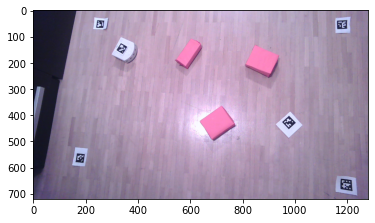

In [8]:
#for faking dynamic camera input
frame_tmp = cv2.imread('test3.png')
frame = cv2.cvtColor(frame_tmp, cv2.COLOR_BGR2RGB)
# frame = cv2.imread('test_im_floor.jpeg')
plt.imshow(frame)

In [12]:
%matplotlib qt
# %matplotlib inline #not working
fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(2,1,1)
ax2 = fig.add_subplot(2,1,2)
while(1):
    ax1.cla()
    ax1.imshow(warpedimg_clean_annotated)
    ax2.cla()
    ax2.imshow(warpedimg_annotated)
    plt.pause(0.001)
    clear_output(wait=True)

KeyboardInterrupt: 